In [1]:
!pip install rdkit

In [27]:
%run MetaboliteModelFunctions.ipynb

In [3]:
trainFile = 'training_data.csv'
testFile = 'test_data.csv'
train_X, train_Y, test_X, test_Y = makeTrainAndTest(trainFile, testFile, 'pIC50')

In [4]:
tX = test_X
tY = test_Y

test_X = train_X
test_Y = train_Y

train_X = tX
train_Y = tY

In [38]:
met.inportStatements()

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

def loopedKfoldCrossVal(modelType, cycleNum, train_X, train_y):
    modelTypes = {'RF': RandomForestRegressor()}

    num_cv = cycleNum
    predictions_filename = f'CV{modelType}_predictions.csv'

    predStats = {'r2_sum': 0, 'rmsd_sum': 0, 'bias_sum': 0, 'sdep_sum': 0}
    predictionStats = pd.DataFrame(data=np.zeros((num_cv, 6)), columns=['Fold', 'Number of Molecules', 'r2', 'rmsd', 'bias', 'sdep'])

    myPreds = pd.DataFrame(index=train_y.index, columns=['Prediction', 'Fold'])
    myPreds['Prediction'] = np.nan
    myPreds['Fold'] = np.nan

    train_test_split = KFold(n_splits=num_cv, shuffle=True, random_state=1)

    for n, (train_idx, test_idx) in enumerate(train_test_split.split(train_X)):
        x_train = train_X.iloc[train_idx]
        x_test = train_X.iloc[test_idx]
        y_train = train_y.iloc[train_idx]
        y_test = train_y.iloc[test_idx]

        model = modelTypes[modelType]

        # Train model
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        # Metrics calculations
        r2 = r2_score(y_test, y_pred)
        rmsd = mean_squared_error(y_test, y_pred, squared=False)
        bias = np.mean(y_pred - y_test)
        sdep = np.std(y_pred - y_test)

        # Update stats
        predStats['r2_sum'] += r2
        predStats['rmsd_sum'] += rmsd
        predStats['bias_sum'] += bias
        predStats['sdep_sum'] += sdep

        # Update predictions
        myPreds.loc[test_idx, 'Prediction'] = y_pred
        myPreds.loc[test_idx, 'Fold'] = n + 1

        # Ensure correct number of values are assigned
        predictionStats.iloc[n] = [n + 1, len(test_idx), r2, rmsd, bias, sdep]

    # Calculate averages
    r2_av = predStats['r2_sum'] / num_cv
    rmsd_av = predStats['rmsd_sum'] / num_cv
    bias_av = predStats['bias_sum'] / num_cv
    sdep_av = predStats['sdep_sum'] / num_cv

    # Create a DataFrame row for averages
    avg_row = pd.DataFrame([['Average', len(train_y), r2_av, rmsd_av, bias_av, sdep_av]], columns=predictionStats.columns)

    # Append average row to the DataFrame
    predictionStats = pd.concat([predictionStats, avg_row], ignore_index=True)

    myPreds.to_csv(predictions_filename, index=True)
    predictionStats.to_csv(f'CV{modelType}_stats.csv', index=False)

    return myPreds, predictionStats


In [65]:
myPreds, predictionStats = loopedKfoldCrossVal('RF', 10, test_X, test_Y)

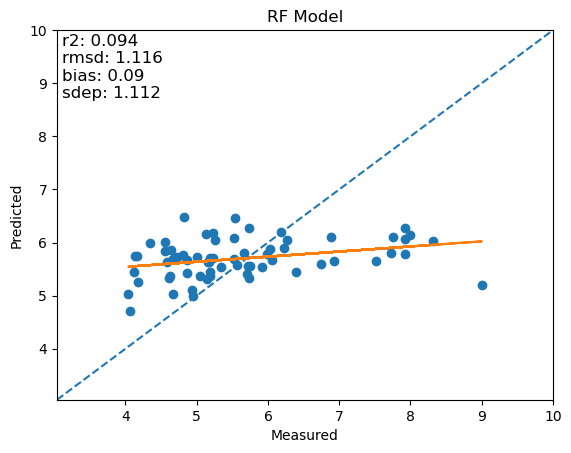

<Figure size 640x480 with 0 Axes>

In [29]:
metaboliteModelStuff(testFile, testFile)